In [1]:
import numpy as np 
import pandas as pd 
import six
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import sys

Wetterdata=pd.read_csv('../data/wetter/wetter_19560101_20190226_ohne_Sonne.csv')

df = pd.DataFrame(Wetterdata.head(1))

In [2]:
y = Wetterdata['Niederschlagsform']
del Wetterdata['Niederschlagsform']

featurenames = Wetterdata.columns

X = Wetterdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


#Create necessary csv-files. Do this only on first execution
# X_test.to_csv("../data/wetter/X_test.csv", header = True, index=False)
# X_train.to_csv("../data/wetter/X_train.csv", header = True, index=False)
# y_train.to_csv("../data/wetter/y_train.csv", header = True, index=False)
# y_test.to_csv("../data/wetter/y_test.csv", header = True, index=False)

# X_test.to_csv("../data/wetter/X_test_vor.csv", header = True, index=False)
# X_train.to_csv("../data/wetter/X_train_vor.csv", header = True, index=False)
# y_train.to_csv("../data/wetter/y_train_vor.csv", header = True, index=False)
# y_test.to_csv("../data/wetter/y_test_vor.csv", header = True, index=False)



In [3]:
#Use RFECV to select the most promising features for representation on website
selector = ensemble.RandomForestClassifier(n_estimators=10) 
rfecv = RFECV(estimator=selector, step=1, cv=5,scoring='accuracy') 
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])
print(rfecv.estimator_.feature_importances_ )

Optimal number of features : 11
Best features : Index(['Wind_max', 'Wind_mittel', 'Schneehöhe', 'Bedeckungsgrad', 'Dampfdruck',
       'Luftdruck', 'Temp_mittel', 'rel_Feuchte', 'Temp_max_2m', 'Temp_min_2m',
       'Temp_min_5cm'],
      dtype='object')
[0.08921698 0.06276671 0.00542036 0.27074153 0.05800782 0.14626328
 0.06030275 0.12273136 0.07108031 0.05080752 0.06266137]


In [4]:
clf = tree.DecisionTreeClassifier(random_state=4, max_depth=5)

#Simple Decision Tree without modifications

clf.fit(X_train, y_train)
dtPredictionsTrain = clf.predict(X_train)
dtPredictionsTest = clf.predict(X_test)

print("Simple Dec Tree accuracy on the training set:", accuracy_score(y_train, dtPredictionsTrain))
print("Simple Dec Tree accuracy on the test set:", accuracy_score(y_test, dtPredictionsTest))

print(pd.DataFrame(
    confusion_matrix(y_test, dtPredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))

#Create Confusionmatrix and calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test, dtPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
print("sens",sensitivity)
print("spez", specificity)

Simple Dec Tree accuracy on the training set: 0.8160584846044235
Simple Dec Tree accuracy on the test set: 0.8025440878866724
                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1636                      948
True precipitation                             418                     3916
sens 0.9035532994923858
spez 0.6331269349845201


In [5]:
#Use these parameters to find better decision tree
param_grid = {
    'max_depth': [3,4,11, None],
    'min_samples_leaf': [1,2,3,78],
    'min_samples_split':[2,3,4,5,7,34],
    'max_features': [None,10],
    'criterion': ['gini','entropy'],
    'random_state': [4,793]
}

GS_clf = GridSearchCV(clf, param_grid, n_jobs=-1)

GS_clf.fit(X_train, y_train)
print('best score: ', GS_clf.best_score_)
print("best params -", GS_clf.best_params_)


/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best score:  0.8135183693699275
best params - {'criterion': 'entropy', 'max_depth': 11, 'max_features': 10, 'min_samples_leaf': 78, 'min_samples_split': 2, 'random_state': 4}


In [6]:
clfBestParams = GS_clf.best_estimator_
clfBestParams.fit(X_train, y_train)

decisionTreePredictionsTrain = clfBestParams.predict(X_train)

decisionTreePredictionsTest = clfBestParams.predict(X_test)


print("Tuned Tree accuracy on the training set:", accuracy_score(y_train, decisionTreePredictionsTrain))
print("Tuned Tree accuracy on the test set:", accuracy_score(y_test, decisionTreePredictionsTest))


Tuned Tree accuracy on the training set: 0.8271482559940524
Tuned Tree accuracy on the test set: 0.8071697022260769


In [7]:
#New approach using RandomizedSearchCV

criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
max_features = [int(x) for x in np.linspace(start = 1, stop = 11, num = 11)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
random_state = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 200)]

random_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}

dt = tree.DecisionTreeClassifier()
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 1000, cv = 2, verbose=2, random_state=42, n_jobs = -1)
dt_random.fit(X_train, y_train)

print(dt_random.best_params_)

base_model = clf

#Calculate and show improvement
base_accuracy = accuracy_score(y_test, dtPredictionsTest)
print("base_accuracy: ",base_accuracy)
best_random = dt_random.best_estimator_
dt_randomPredictionsTest = dt_random.predict(X_test)
random_accuracy = accuracy_score(y_test, dt_randomPredictionsTest)
print("random_accuracy: ",random_accuracy)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))



Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   13.1s


{'random_state': 793, 'min_samples_split': 34, 'min_samples_leaf': 78, 'max_features': 10, 'max_depth': 11, 'criterion': 'entropy'}
base_accuracy:  0.8025440878866724
random_accuracy:  0.8119398670135878
Improvement of 1.17%.


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   22.6s finished


In [8]:
#Print Confusionmatrix
print(pd.DataFrame(
    confusion_matrix(y_test, decisionTreePredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))

                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1764                      820
True precipitation                             514                     3820


In [9]:
#Print sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test, decisionTreePredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)

sensitivity 0.8814028610982926
Specificity 0.6826625386996904


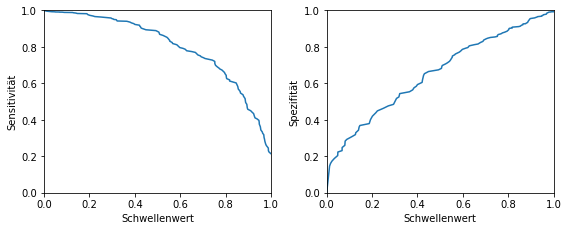

In [15]:
def roc(clf):
    """
    Plots the ROC on test data. 
    
    Parameters
    ----------
    clf : DecisionTreeClassifier or RandomForestClassifier
        The model of the classifier
    """
    
    #Calculate prediction probabilities
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    #Calculate roc_auc
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    #Plot ROC
    plt.plot(fpr,tpr)
    #Plot random classifier performance
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([1, 0])
    plt.xticks([1.0,0.8,0.6,0.4,0.2,0.0], [0.0,0.2,0.4,0.6,0.8,1.0])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivität')
    plt.xlabel('Spezifität')
    
    plt.tight_layout()
    plt.show()
    print(roc_auc)
    
def sens(clf):
    """
    Plots the sensitivity/true positive rate/recall on test data.
    
    Parameters
    ----------
    clf : DecisionTreeClassifier or RandomForestClassifier
        The model of the classifier
    """
    
    #Calculate prediction probabilities
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    #Calculate roc_auc
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
     
    #Plot sensitivity
    plt.plot(threshold,tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivität')
    plt.xlabel('Schwellenwert')
    
    plt.tight_layout()
    plt.show()
    
def spez(clf):
    """
    Plots the specificity on test data.
    
    Parameters
    ----------
    clf : DecisionTreeClassifier or RandomForestClassifier
        The model of the classifier
    """
    
    #Calculate prediction probabilities
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    #Calculate roc_auc
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    #Plot specificity
    plt.plot(threshold,1-fpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Spezifität')
    plt.xlabel('Schwellenwert')
    
    plt.tight_layout()
    plt.show()
    
def sensspez(clf):
    """
    Plots the sensitivity and specificity on test data in a combined plot.
    
    Parameters
    ----------
    clf : DecisionTreeClassifier or RandomForestClassifier
        The model of the classifier
    """
    
    #Calculate prediction probabilities
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    #Calculate roc_auc
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.subplot(221)
    #Plot sensitivity
    plt.plot(threshold,tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivität')
    plt.xlabel('Schwellenwert')
    
    plt.subplot(222)
    #Plot specificity
    plt.plot(threshold,1-fpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Spezifität')
    plt.xlabel('Schwellenwert')
    
    plt.tight_layout()
    plt.show()

sensspez(clfBestParams)

/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy on the training set: 0.9899634471222353
Random Forest accuracy on the test set: 0.8048568950563747
                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1909                      675
True precipitation                             675                     3659
sensitivity 0.8442547300415321
Specificity 0.7387770897832817


/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest optimised accuracy on the training set: 0.8729942382751998
Random Forest optimised accuracy on the test set: 0.7548424400115641


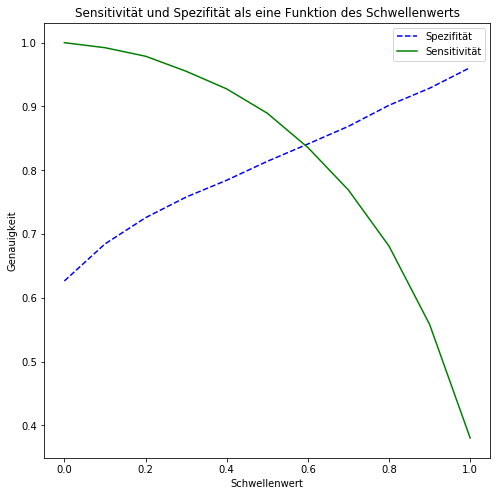

In [12]:
#Random Forest
rf = ensemble.RandomForestClassifier(random_state=7)
rf.fit(X_train, y_train)

rfPredictionsTrain = rf.predict(X_train)

rfPredictionsTest = rf.predict(X_test)


print("Random Forest accuracy on the training set:", accuracy_score(y_train, rfPredictionsTrain))

print("Random Forest accuracy on the test set:", accuracy_score(y_test, rfPredictionsTest))

#Calculate Confusionmatrix and Sensitivity and Specificity
print(pd.DataFrame(
    confusion_matrix(y_test, rfPredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))

tn, fp, fn, tp = confusion_matrix(y_test, rfPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)

#Optimized Random Forest for sensitivity
rf_opt = ensemble.RandomForestClassifier(n_jobs=-1, random_state=1)


rf_opt.fit(X_train, y_train)
y_scores = rf_opt.predict_proba(X_test)[:,1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)


def plot_precision_recall_vs_threshold(p, r, thresholds):
    """
    Plots the precision-recall-graph for different thresholds. 
    Uses output of precision_recall_curve function in scikit-learn
    
    Parameters
    ----------
    p : numpy.ndarray
        The list of all precision values
    r : numpy.ndarray
        The list of all recall values
    thresholds : numpy.ndarray
        The list of all thresholds
    """
    
    plt.figure(figsize=(8, 8))
    plt.title("Sensitivität und Spezifität als eine Funktion des Schwellenwerts")
    plt.plot(thresholds, p[:-1], "b--", label="Spezifität")
    plt.plot(thresholds, r[:-1], "g-", label="Sensitivität")
    plt.ylabel("Genauigkeit")
    plt.xlabel("Schwellenwert")
    plt.legend(loc='best')
    
threshold = 0.2
plot_precision_recall_vs_threshold(p, r, thresholds)

rf_optPredictionsTrain = rf_opt.predict(X_train)

rf_optPredictionsTest = rf_opt.predict(X_test)


predicted_probaTrain = rf_opt.predict_proba(X_train)
rf_optPredictionsTrain = (predicted_probaTrain [:,1] >= threshold).astype('int')

predicted_probaTest = rf_opt.predict_proba(X_test)
rf_optPredictionsTest = (predicted_probaTest [:,1] >= threshold).astype('int')


print("Random Forest optimised accuracy on the training set:", accuracy_score(y_train, rf_optPredictionsTrain))

print("Random Forest optimised accuracy on the test set:", accuracy_score(y_test, rf_optPredictionsTest))


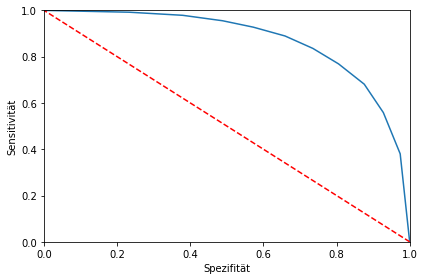

0.871520331713673


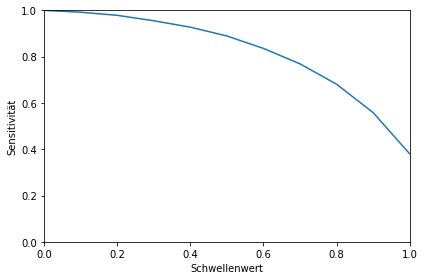

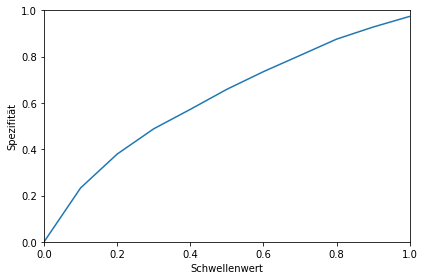

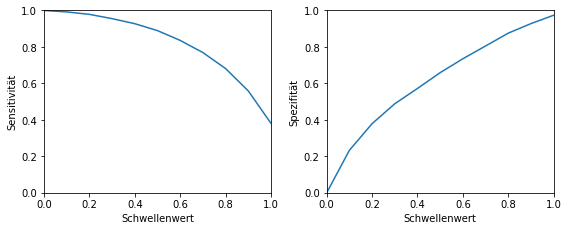

In [16]:
roc(rf_opt)
sens(rf_opt)
spez(rf_opt)
sensspez(rf_opt)

K Nearest Neighbors accuracy on the training set: 0.8254754971810916
K Nearest Neighbors accuracy on the test set: 0.8138190228389708


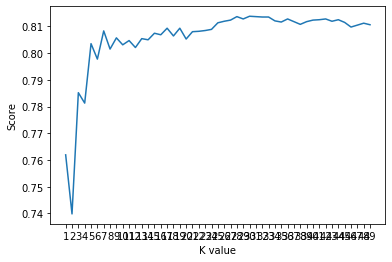

Maximum KNN Score is 81.38% at
[30]
                        Predicted No precipitation  Predicted precipitation
True Not precipitation                        1843                      741
True precipitation                             547                     3787
sensitivity 0.8737886479003231
Specificity 0.7132352941176471


In [14]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

knnPredictionsTrain = knn.predict(X_train)

knnPredictionsTest = knn.predict(X_test)


print("K Nearest Neighbors accuracy on the training set:", accuracy_score(y_train, knnPredictionsTrain))

print("K Nearest Neighbors accuracy on the test set:", accuracy_score(y_test, knnPredictionsTest))

scoreList = []
for i in range(1,50):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,50), scoreList)
plt.xticks(np.arange(1,50,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

m = max(scoreList)
[i for i, j in enumerate(scoreList) if j == m]

print("Maximum KNN Score is {:.2f}% at".format(m*100))
print([i+1 for i, j in enumerate(scoreList) if j == m])
#Sensitivity and Specificity
print(pd.DataFrame(
    confusion_matrix(y_test, knnPredictionsTest),
    columns=['Predicted No precipitation', 'Predicted precipitation'],
    index=['True Not precipitation', 'True precipitation']
))
tn, fp, fn, tp = confusion_matrix(y_test, knnPredictionsTest).ravel()
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)

print("sensitivity", sensitivity)
print("Specificity", specificity)


In [8]:
#Store models permanently
# dtModel_GS = open("models/dtmodel_gs.pkl","wb")
# joblib.dump(GS_clf,dtModel_GS)
# dtModel_GS.close

# dtModel_simple = open("models/dtmodel_simple.pkl", "wb")
# joblib.dump(clf, dtModel_simple)
# dtModel_simple.close

# knn_model = open("models/knn_model.pkl", "wb")
# joblib.dump(knn, knn_model)
# knn_model.close

# rf_model = open("models/rf_model.pkl", "wb")
# joblib.dump(rf, rf_model)
# rf_model.close

# rf_opt_model = open("models/rf_opt_model.pkl", "wb")
# joblib.dump(rf_opt, rf_opt_model)
# rf_opt_model.close

In [19]:
# #clf_2 for other Decision Tree Example
# clf_2 = tree.DecisionTreeClassifier(random_state=333, criterion='gini', min_samples_leaf=6, max_features=0.1)
# clf_2.fit(X_train,y_train)
# dt2PredictionsTrain = clf_2.predict(X_train)
# dt2PredictionsTest = clf_2.predict(X_test)

# print("Simple Dec Tree 2 accuracy on the training set:", accuracy_score(y_train, dt2PredictionsTrain))
# print("Simple Dec Tree 2 accuracy on the test set:", accuracy_score(y_test, dt2PredictionsTest))

# tree.export_graphviz(clf_2, out_file='wetter_tree_ohne_Sonne_2.dot', feature_names= X_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png wetter_tree_ohne_Sonne_2.dot -o ../static/images/wetter_tree_ohne_Sonne_2.png

# tree.export_graphviz(clfBestParams, out_file='wetter_tree_ohne_Sonne_gs.dot', feature_names= X_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png wetter_tree_ohne_Sonne_gs.dot -o ../static/images/wetter_tree_ohne_Sonne_gs.png

In [20]:
#Tree for Animation

# AnimationData=pd.read_csv('../data/wetter/wetter_20170826_20190226_ohne_Sonne_animation.csv')
# y_anim = AnimationData['Niederschlagsform']

# del AnimationData['Niederschlagsform']


# X_anim = AnimationData
# X_anim_train, X_anim_test, y_anim_train, y_anim_test = train_test_split(X_anim, y_anim, test_size=0.3, random_state=1)


# animation = tree.DecisionTreeClassifier(random_state=3, criterion='gini', min_samples_leaf=5, max_features=1, max_depth=3)
# animation.fit(X_anim_train,y_anim_train)
# animationPredictionsTrain = animation.predict(X_anim_train)
# animationPredictionsTest = animation.predict(X_anim_test)

# print("Animation accuracy on the training set:", accuracy_score(y_anim_train, animationPredictionsTrain))
# print("Animation accuracy on the test set:", accuracy_score(y_anim_test, animationPredictionsTest))

# tree.export_graphviz(animation, out_file='wetter_tree_ohne_Sonne_animation.dot', feature_names= X_anim_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png -Gdpi=600 wetter_tree_ohne_Sonne_animation.dot -o ../static/images/wetter_tree_ohne_Sonne_animation.png

In [21]:
#Trees for different parameter explanation

# for i in np.arange(1,5):
#     t = tree.DecisionTreeClassifier(max_depth=i)
#     t.fit(X_train, y_train)
#     tree.export_graphviz(t, out_file='max_depth_{}.dot'.format(i), feature_names= X_train.columns,
#                                 class_names= ['0', '1'],
#                                 filled=True, rounded=True,
#                                 special_characters=True)

# !dot -T png -Gdpi=300 max_depth_1.dot -o ../static/images/max_depth_1.png
# !dot -T png -Gdpi=300 max_depth_2.dot -o ../static/images/max_depth_2.png
# !dot -T png -Gdpi=300 max_depth_3.dot -o ../static/images/max_depth_3.png
# !dot -T png -Gdpi=300 max_depth_4.dot -o ../static/images/max_depth_4.png